# Prostate Cancer Classification Analysis

# Imports

In [41]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.metrics import f1_score, accuracy_score, fbeta_score, confusion_matrix, make_scorer
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.pipeline import Pipeline as imb_pipeline

# Functions

In [38]:

def check_for_null_dupes(df):
  print(f"The Amount of Nulls: {df.isna().sum()}")
  print(f"The Amount of Dupes: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.xlabel("Target Class")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()
  
def plot_model_performance(df, y, axis):
    
    fig, ax = plt.subplots(figsize=(10,6))
    df.plot.bar(x="Model", y=y, ax=ax)
    ax.set_xlabel("Model Performance")
    ax.set_ylabel(axis)
    ax.set_title("Model Performance")
    plt.legend(y)
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.show()

def plot_confusion_matrix(y_test, y_pred, model_name):
  
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(15, 8))
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.xlabel("True Labels")
  plt.ylabel("Predicted Labels")
  plt.title(f"Model: {model_name}")
  plt.xticks(rotation=45)
  plt.show()

def create_train_test_splits(X, y):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
  
  return X_train, X_test, y_train, y_test

def grab_selected_models(model_names):
  models = {
    "LR": LogisticRegression(max_iter=2000),
    "SVC": SVC(),
    "KNN":KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "GBC": GradientBoostingClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in model_names]

def grab_selected_sampling_models(model_names):
  models = {
    "SMOTE":SMOTE(),
    "BL-SMOTE":BorderlineSMOTE(),
    "ADASYN": ADASYN(),
    "KNN-SMOTE": SMOTE(k_neighbors=5)
  }
  
  return [models[model] for model in model_names]

def create_pipeline(model_name, model):
  steps = [
  ("Scaler", StandardScaler()),
  ("PowerTransformer", PowerTransformer()),
  (model_name, model)
]
  
  return sklearnPipeline(steps=steps)

def create_imb_pipeline(sampling_model_name, sampling_model, model_name, model):
  
  steps = [
    ("Scaler", StandardScaler()),
    ("PowerTransformer", PowerTransformer()),
    (sampling_model_name, sampling_model),
    (model_name, model)
  ]
  return imb_pipeline(steps=steps)
  
def evaluate_model(model, X, y, scoring_metric):
  
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
  scores = cross_val_score(model, X, y, scoring=scoring_metric, cv=cv, n_jobs=-1)
  predictions = cross_val_predict(model, X, y, cv=5)
  acc = accuracy_score(y, predictions)
  f1_metric = f1_score(y, predictions, average="binary")
  f2_metric= fbeta_score(y, predictions, beta=2)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(f1_metric, 3), 
    round(f2_metric,3)
  ]

def test_selected_models(model_names, models, X, y, scoring_metric):
  gather_metrics = []
  for model, model_name in zip(models, model_names):
    pipeline = create_pipeline(model_name, model)
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    
    gather_metrics.append(
      {
        "Model": model_name,
        "Mean": scores[0],
        "Var": scores[1],
        "STD": scores[2],
        "Test-Acc":scores[3],
        "F1-Score":scores[4],
        "F2-Score":scores[5]
      }
    )
    
  df = pd.DataFrame(gather_metrics).sort_values(by="Mean", ascending=False).reset_index()
  plot_model_performance(df,["Mean", "Var", "STD", "Test-Acc", "F1-Score", "F2-Score"], "Metrics")
  print(df)

def test_selected_sampling_models(sampling_model_names, sampling_models, model_names, models, X, y, scoring_metric):
  gather_metrics = []
  for sample_model, sampling_model_name in zip(sampling_models, sampling_model_names):
    for model, model_name in zip(models, model_names):
      pipeline = create_imb_pipeline(sampling_model_name, sample_model, model_name, model)
      scores = evaluate_model(pipeline, X, y, scoring_metric)
      gather_metrics.append(
        {
          "Model": model_name + "-" + sampling_model_name,
          "Mean": scores[0],
          "Var": scores[1],
          "STD": scores[2],
          "Test-Acc":scores[3],
          "F1-Score":scores[4],
          "F2-Score":scores[5]
        }
      )
  df = pd.DataFrame(gather_metrics).sort_values(by="Mean", ascending=False).reset_index()
  plot_model_performance(df,["Mean", "Var", "STD", "Test-Acc", "F1-Score", "F2-Score"], "Metrics")
  print(df)

def grid_search(X, y, pipelines, params, pipeline_names):
  
  X_train, X_test, y_train, y_test = create_train_test_splits(X, y)
  model_performance = []
  metric = make_scorer(f1_score)
  for pipeline, pipeline_name in zip(pipelines, pipeline_names):
    grid_search = GridSearchCV(pipeline, params[pipeline_name], scoring=metric, cv=10, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    print(f"The Best Params: {best_params}")
    
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="binary")
    f2 = fbeta_score(y_test, y_pred, beta=2)
    
    model_performance.append(
      {
        "Model":pipeline_name,
        "Acc":acc,
        "F1-Score":f1,
        "F2-Score":f2
      }
    )
    
    plot_confusion_matrix(y_test, y_pred, pipeline_name)
  
  df = pd.DataFrame(model_performance).sort_values(by="F1-Score", ascending=False).reset_index()
  plot_model_performance(df, ["Acc", "F1-Score", "F2-Score"], "Metrics")
  print(df)


# EDA Analysis

In [5]:
df = pd.read_csv("/Users/maukanmir/Downloads/prostate.csv")
df

,lcavol,lweight,age,lbph,lcp,gleason,pgg45,lpsa,Target
0,-0.579818,2.769459,50,-1.386294,-1.386294,6,0,-0.430783,0
1,-0.994252,3.319626,58,-1.386294,-1.386294,6,0,-0.162519,0
2,-0.510826,2.691243,74,-1.386294,-1.386294,7,20,-0.162519,0
3,-1.203973,3.282789,58,-1.386294,-1.386294,6,0,-0.162519,0
4,0.751416,3.432373,62,-1.386294,-1.386294,6,0,0.371564,0
...,...,...,...,...,...,...,...,...,...
92,2.830268,3.876396,68,-1.386294,1.321756,7,60,4.385147,1
93,3.821004,3.896909,44,-1.386294,2.169054,7,40,4.684443,1
94,2.907447,3.396185,52,-1.386294,2.463853,7,10,5.143124,1
95,2.882564,3.773910,68,1.558145,1.558145,7,80,5.477509,1


# Check For Nulls And Dupes

In [6]:
check_for_null_dupes(df)

The Amount of Nulls: lcavol     0
lweight    0
age        0
lbph       0
lcp        0
gleason    0
pgg45      0
lpsa       0
Target     0
dtype: int64
The Amount of Dupes: 0


# Check Class Imbalance

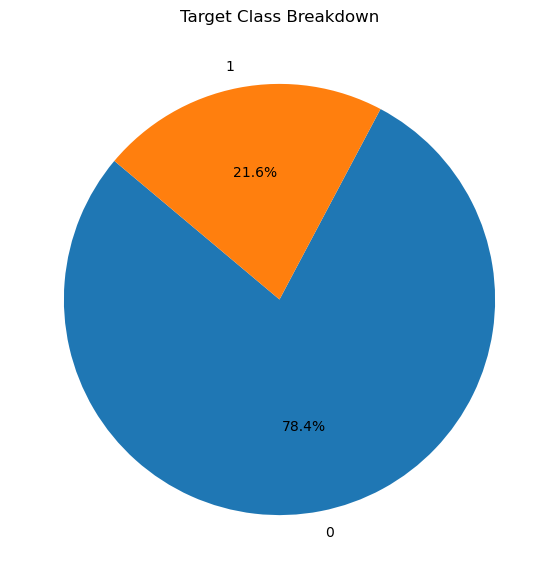

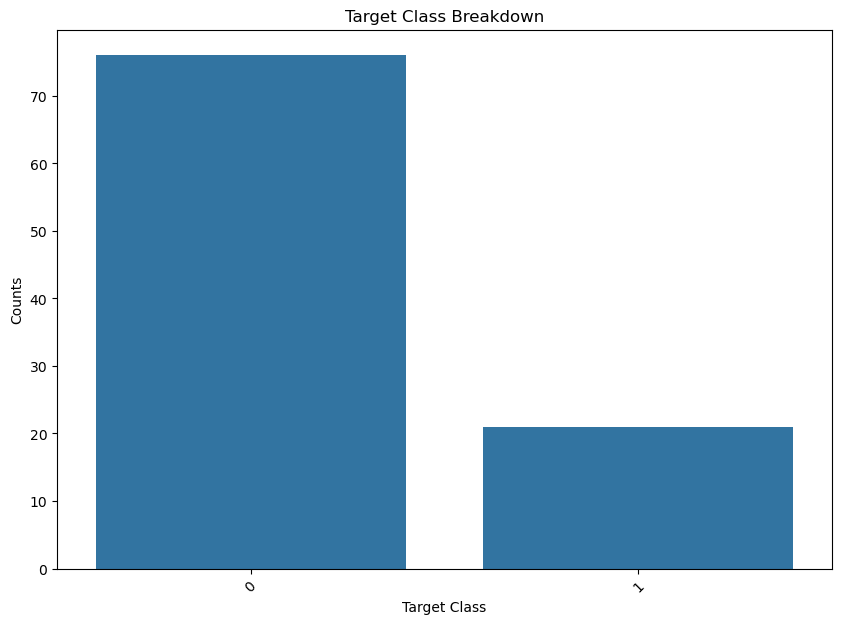

In [7]:
check_class_imbalance(df["Target"])

# Class imbalance for our target class will require sampling methods.

In [8]:
df.dtypes

lcavol     float64
lweight    float64
age          int64
lbph       float64
lcp        float64
gleason      int64
pgg45        int64
lpsa       float64
Target       int64
dtype: object

In [9]:
df.describe()

,lcavol,lweight,age,lbph,lcp,gleason,pgg45,lpsa,Target
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,1.350010,3.628943,63.865979,0.100356,-0.179366,6.752577,24.381443,2.478387,0.216495
std,1.178625,0.428411,7.445117,1.450807,1.398250,0.722134,28.204035,1.154329,0.413995
min,-1.347074,2.374906,41.000000,-1.386294,-1.386294,6.000000,0.000000,-0.430783,0.000000
25%,0.512824,3.375880,60.000000,-1.386294,-1.386294,6.000000,0.000000,1.731656,0.000000
50%,1.446919,3.623007,65.000000,0.300105,-0.798508,7.000000,15.000000,2.591516,0.000000
75%,2.127041,3.876396,68.000000,1.558145,1.178655,7.000000,40.000000,3.056357,0.000000
max,3.821004,4.780383,79.000000,2.326302,2.904165,9.000000,100.000000,5.582932,1.000000


# Visuals

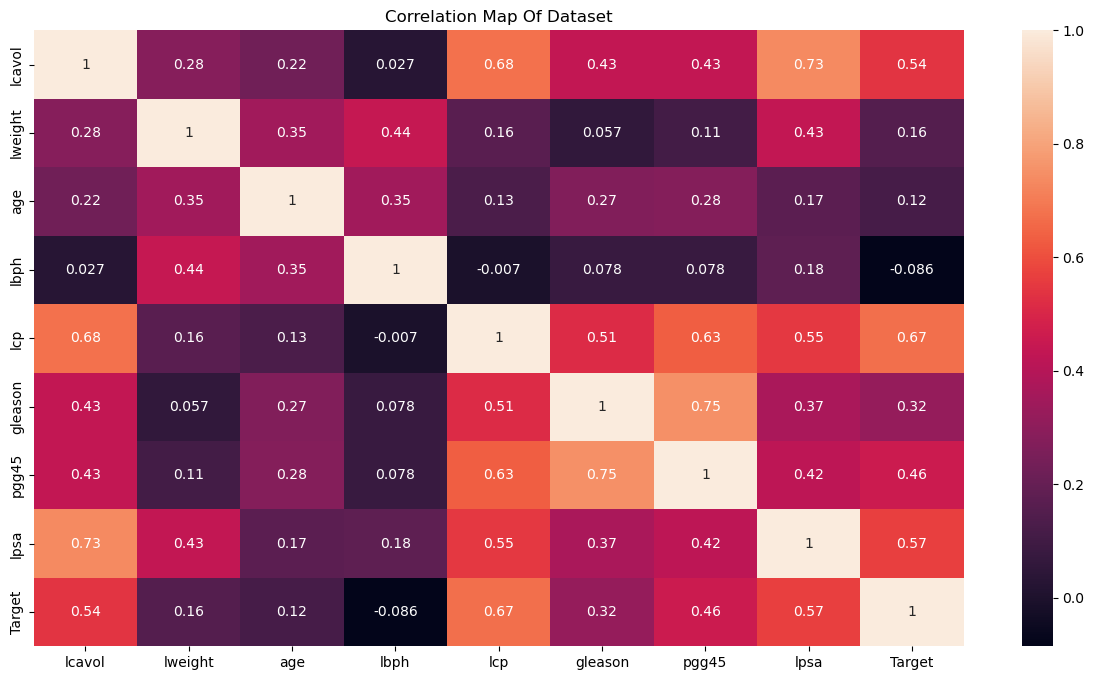

In [10]:
relations = df.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(data=relations, annot=True)
plt.title("Correlation Map Of Dataset")
plt.show()

# A lot of these features are highly correlated, we may be able to reduce our features through PCA analysis given that some maybe not needed.

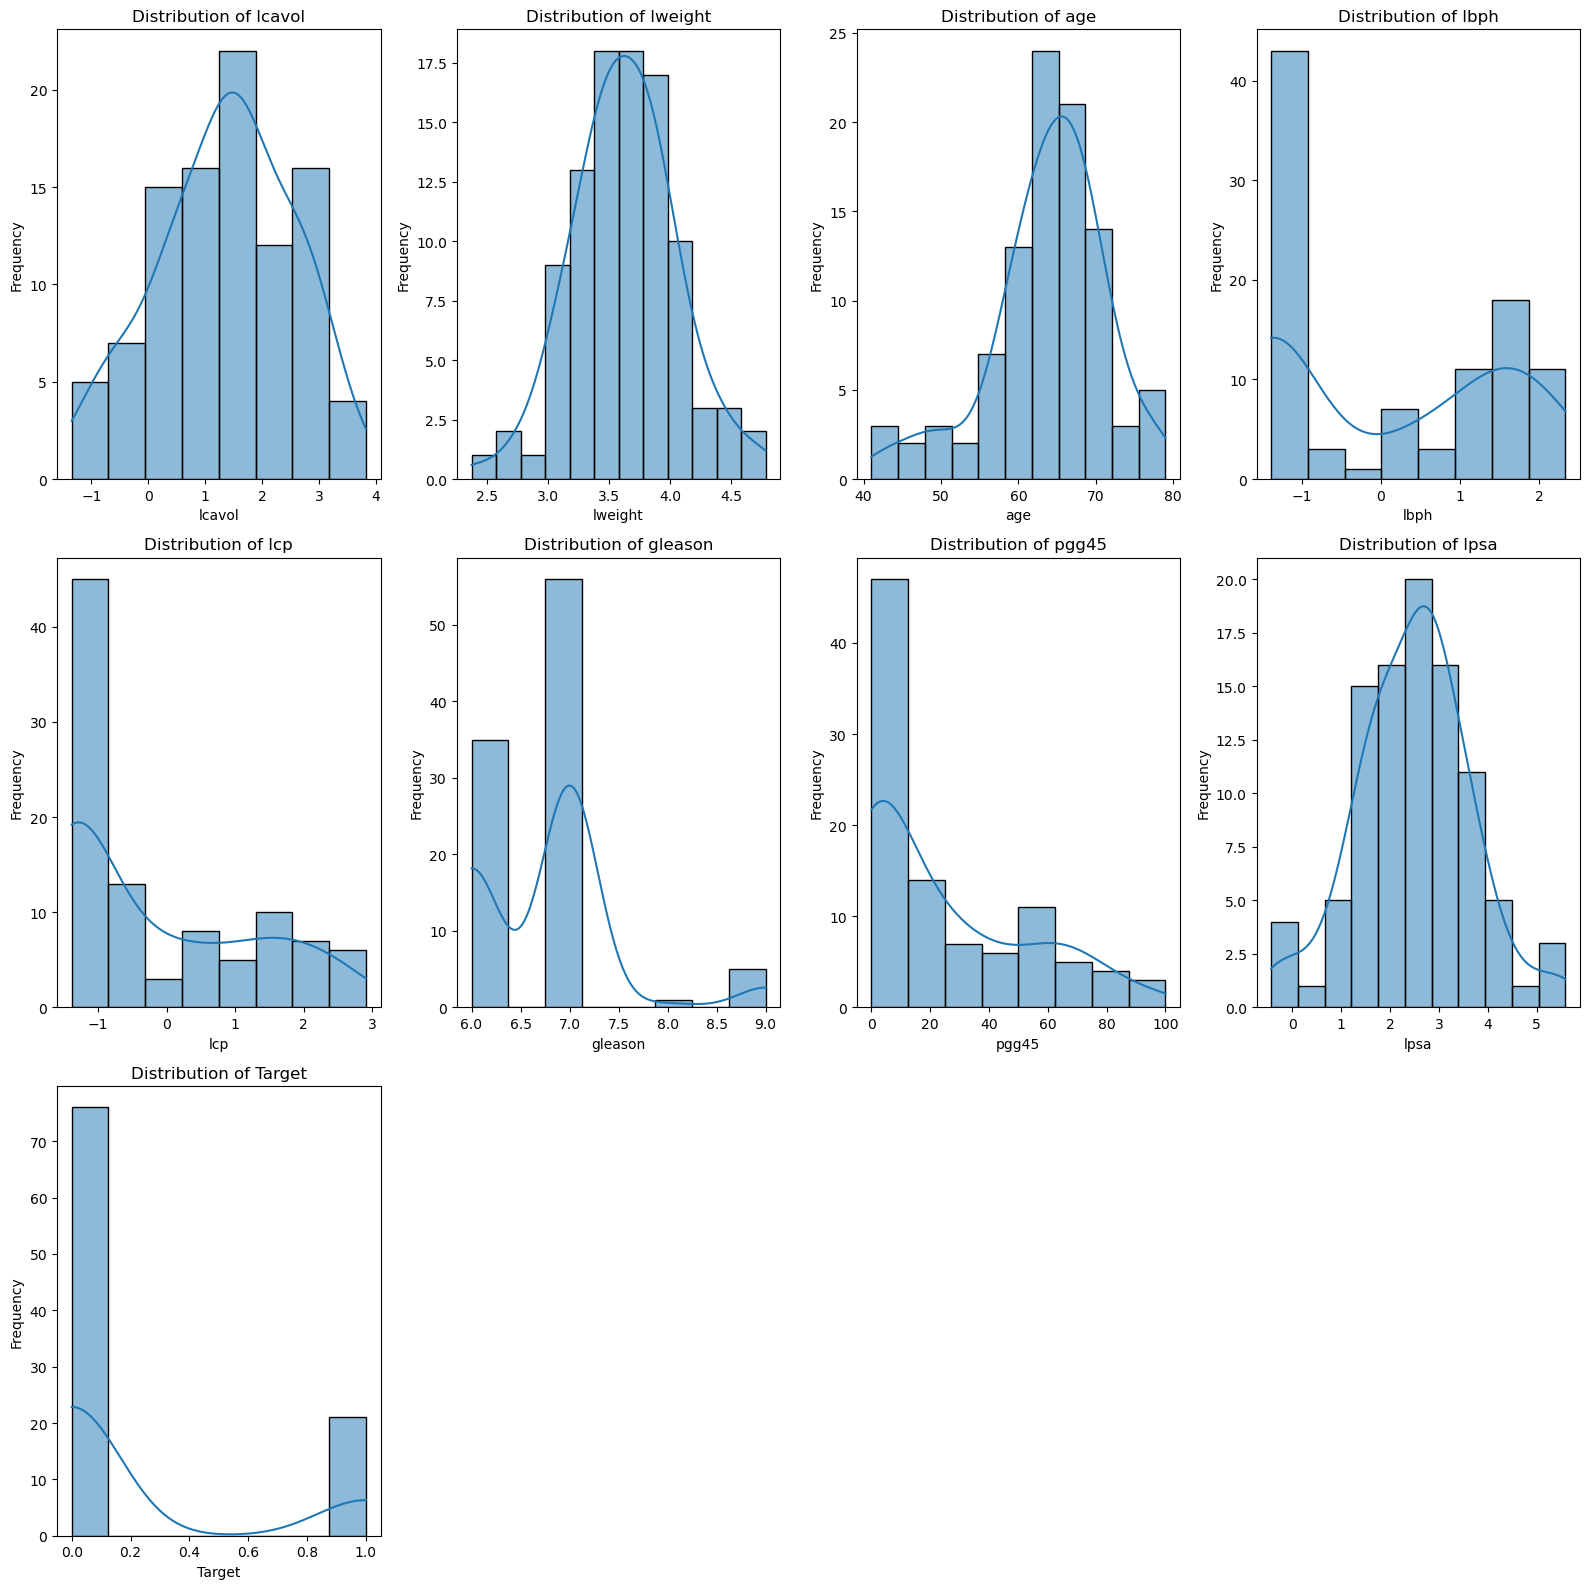

In [11]:
plt.figure(figsize=(16,16))
df_cols = df.columns
rows = len(df.columns)
dims = (rows+3)//4

for idx, col in enumerate(df_cols):
  plt.subplot(dims,4,idx+1)
  sns.histplot(df[col], kde=True)
  plt.title(f"Distribution of {col}")
  plt.xlabel(col)
  plt.ylabel("Frequency")
  
plt.tight_layout()
plt.show()

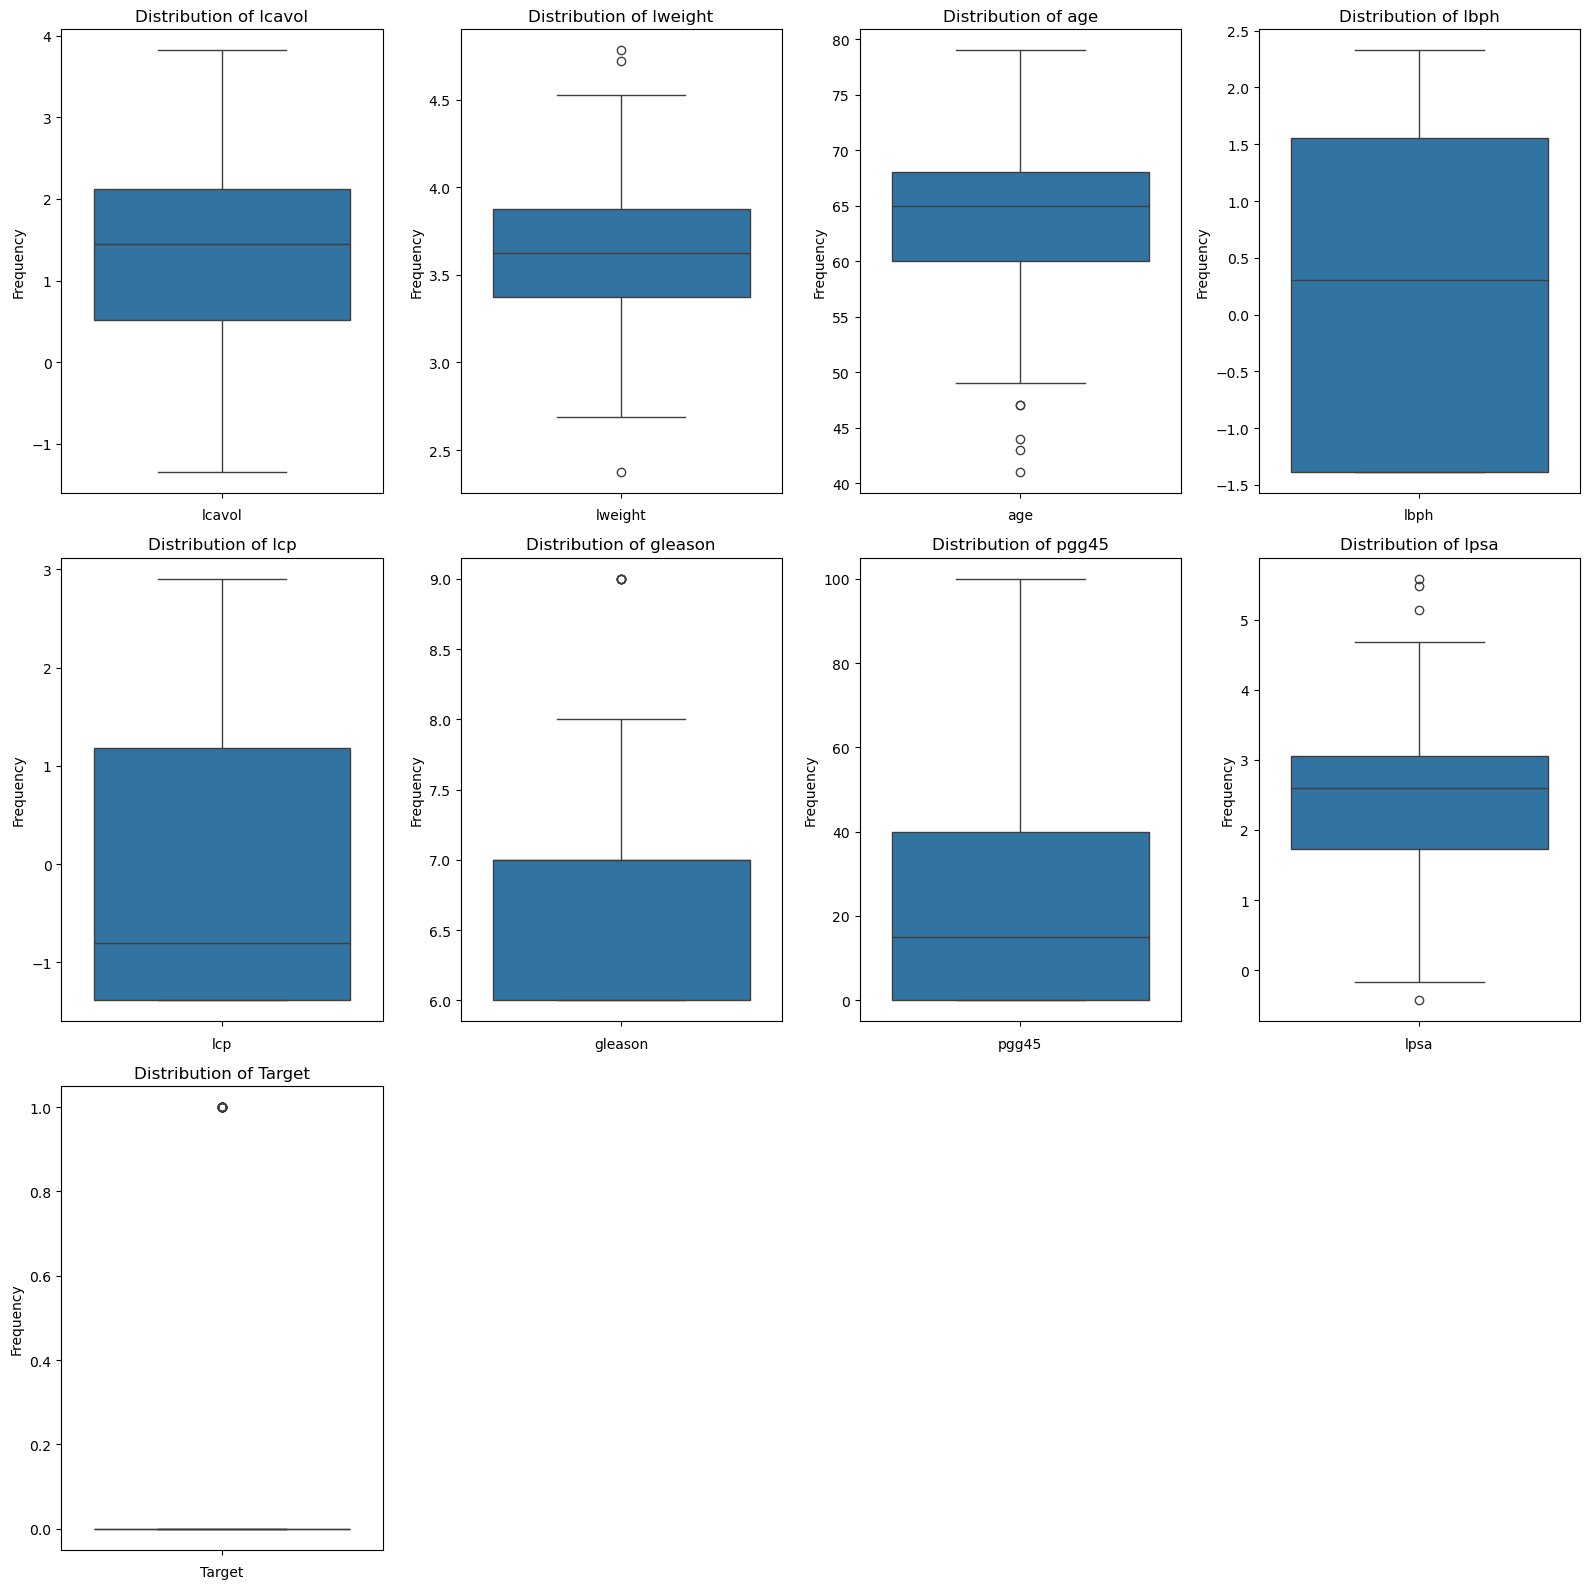

In [12]:
plt.figure(figsize=(16,16))
df_cols = df.columns
rows = len(df.columns)
dims = (rows+3)//4

for idx, col in enumerate(df_cols):
  plt.subplot(dims,4,idx+1)
  sns.boxplot(df[col])
  plt.title(f"Distribution of {col}")
  plt.xlabel(col)
  plt.ylabel("Frequency")
  
plt.tight_layout()
plt.show()

# Our data is fairly normally distributed with a few outliers in certain columns, we will have to evaluate our model and see if this needs to be addressed when we do our testing.

# Create Pipeline

# Separate Feature Variables

In [13]:
X, y = df.drop("Target", axis=1), df["Target"]

# Create Scoring Metrics

In [14]:
f1_metric = make_scorer(f1_score, average="binary")
acc_metric = make_scorer(accuracy_score)

# Create Baseline Model

In [15]:
model = DummyClassifier(strategy="constant", constant=1)
scores = evaluate_model(model, X, y, f1_metric)

print(f"Mean-F1-score: {scores[0]}, Var-score: {scores[1]}, STD:Score: {scores[2]}")
print(f"Acc: {scores[3]}, F1-Score: {scores[4]}, F2-Score: {scores[5]}")

Mean-F1-score: 0.355, Var-score: 0.001, STD:Score: 0.023
Acc: 0.216, F1-Score: 0.356, F2-Score: 0.58


In [16]:
model = DummyClassifier(strategy="constant", constant=1)
scores = evaluate_model(model, X, y, acc_metric)

print(f"Mean-Acc-score: {scores[0]}, Var-score: {scores[1]}, STD:Score: {scores[2]}")
print(f"Acc: {scores[3]}, F1-Score: {scores[4]}, F2-Score: {scores[5]}")

Mean-Acc-score: 0.216, Var-score: 0.0, STD:Score: 0.017
Acc: 0.216, F1-Score: 0.356, F2-Score: 0.58


# Advanced Model Metrics

# F1 Scoring Testing

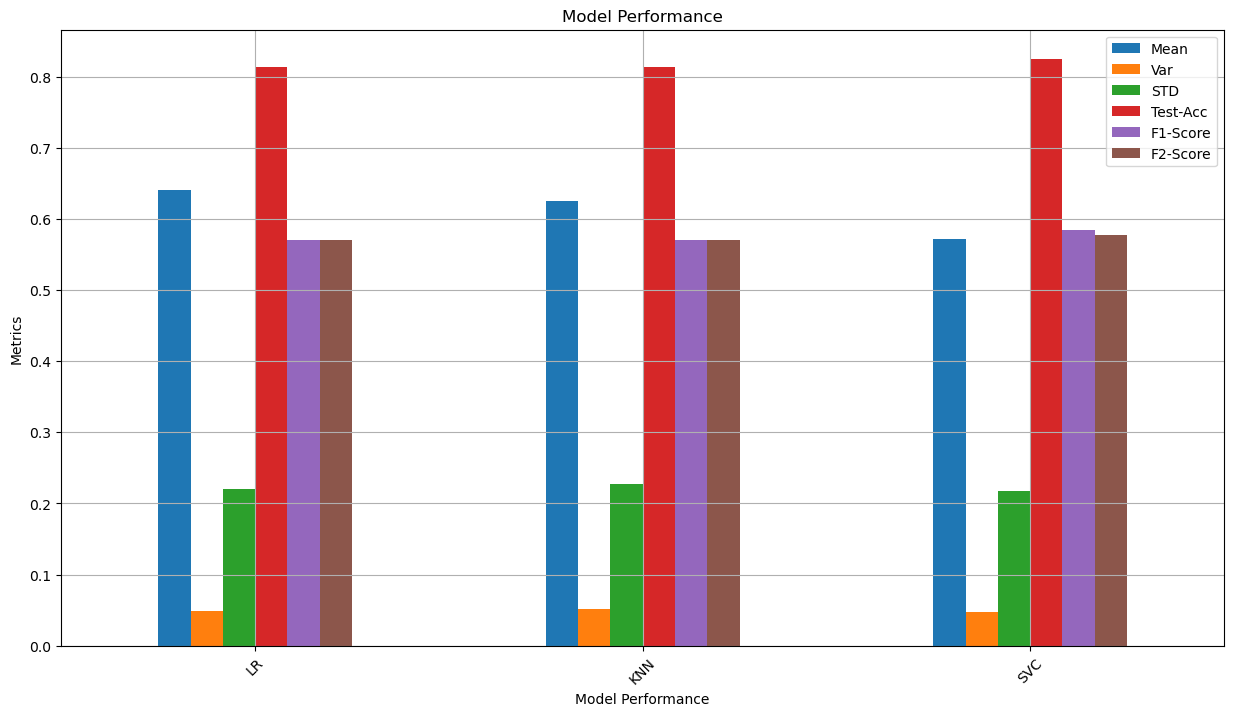

   index Model   Mean    Var    STD  Test-Acc  F1-Score  F2-Score
0      0    LR  0.641  0.049  0.220     0.814     0.571     0.571
1      2   KNN  0.625  0.051  0.227     0.814     0.571     0.571
2      1   SVC  0.572  0.047  0.217     0.825     0.585     0.577


In [17]:
model_names = ["LR", "SVC", "KNN"]
models = grab_selected_models(model_names)
test_selected_models(model_names, models, X, y, f1_metric)

# Testing With Acc Metric

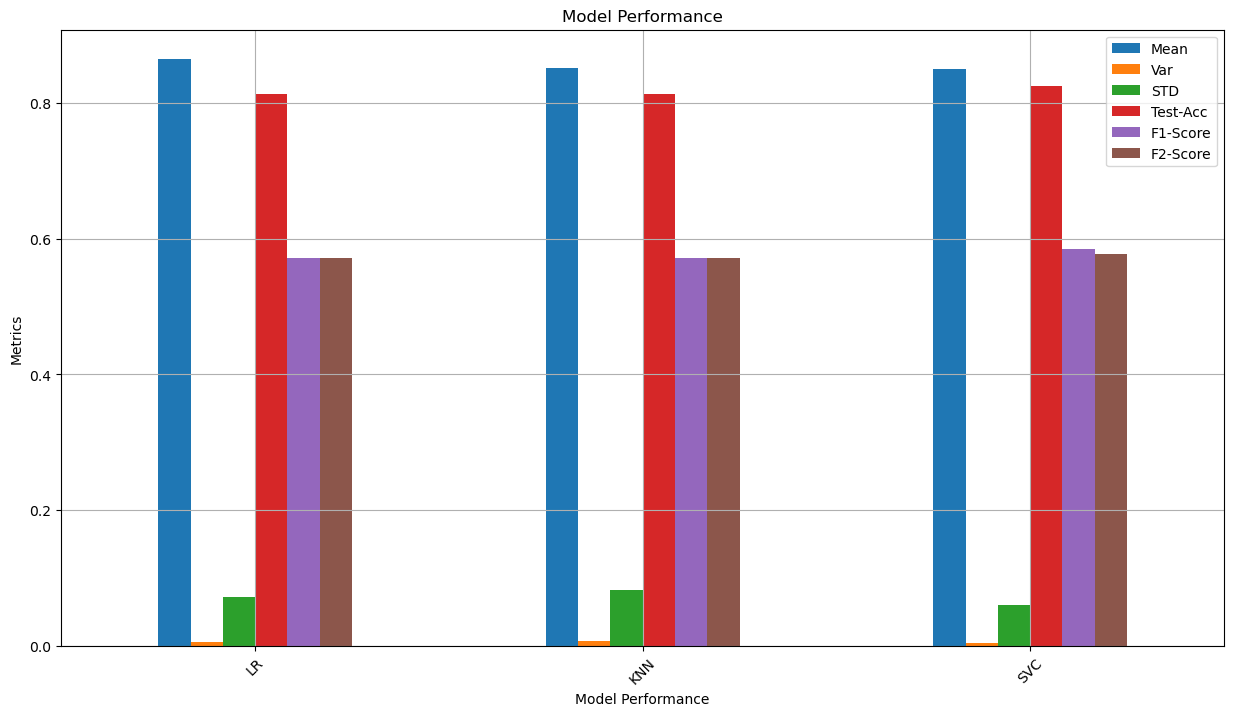

   index Model   Mean    Var    STD  Test-Acc  F1-Score  F2-Score
0      0    LR  0.865  0.005  0.072     0.814     0.571     0.571
1      2   KNN  0.852  0.007  0.082     0.814     0.571     0.571
2      1   SVC  0.850  0.004  0.060     0.825     0.585     0.577


In [18]:
model_names = ["LR", "SVC", "KNN"]
models = grab_selected_models(model_names)
test_selected_models(model_names, models, X, y, acc_metric)

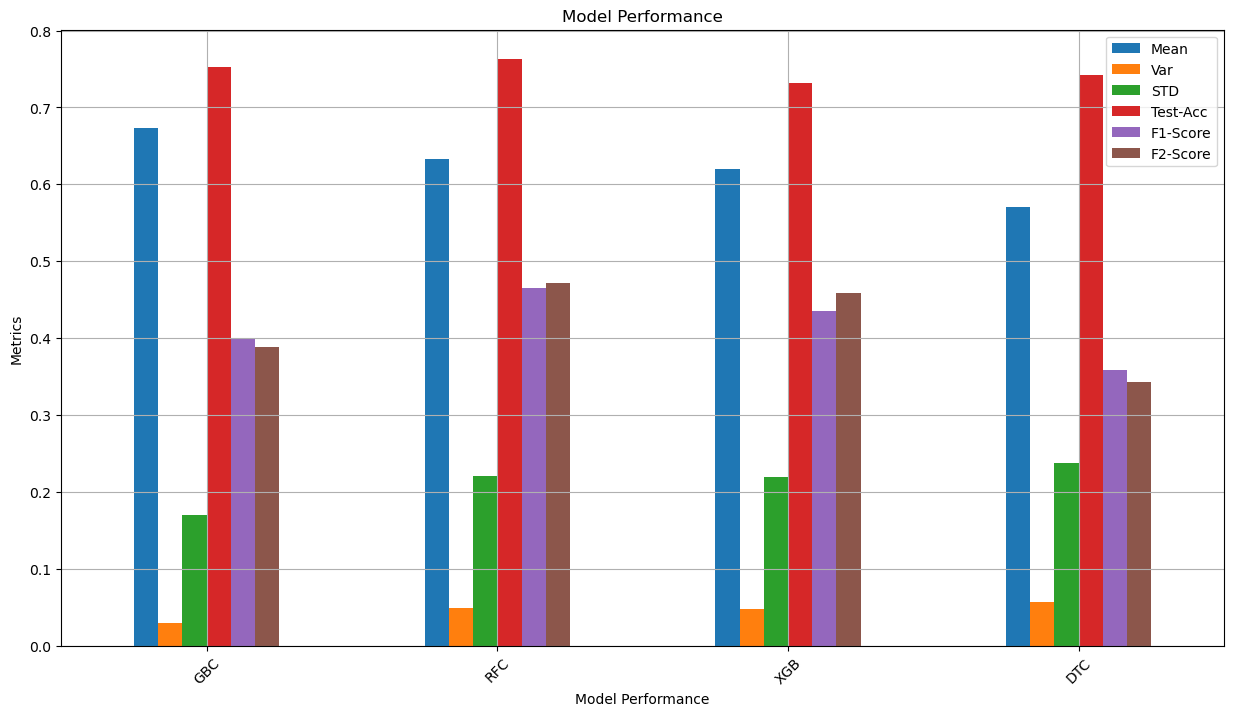

   index Model   Mean    Var    STD  Test-Acc  F1-Score  F2-Score
0      1   GBC  0.673  0.029  0.170     0.753     0.400     0.388
1      0   RFC  0.633  0.049  0.221     0.763     0.465     0.472
2      3   XGB  0.620  0.048  0.220     0.732     0.435     0.459
3      2   DTC  0.571  0.057  0.238     0.742     0.359     0.343


In [19]:
model_names = ["RFC", "GBC", "DTC", "XGB"]
models = grab_selected_models(model_names)
test_selected_models(model_names, models, X, y, f1_metric)

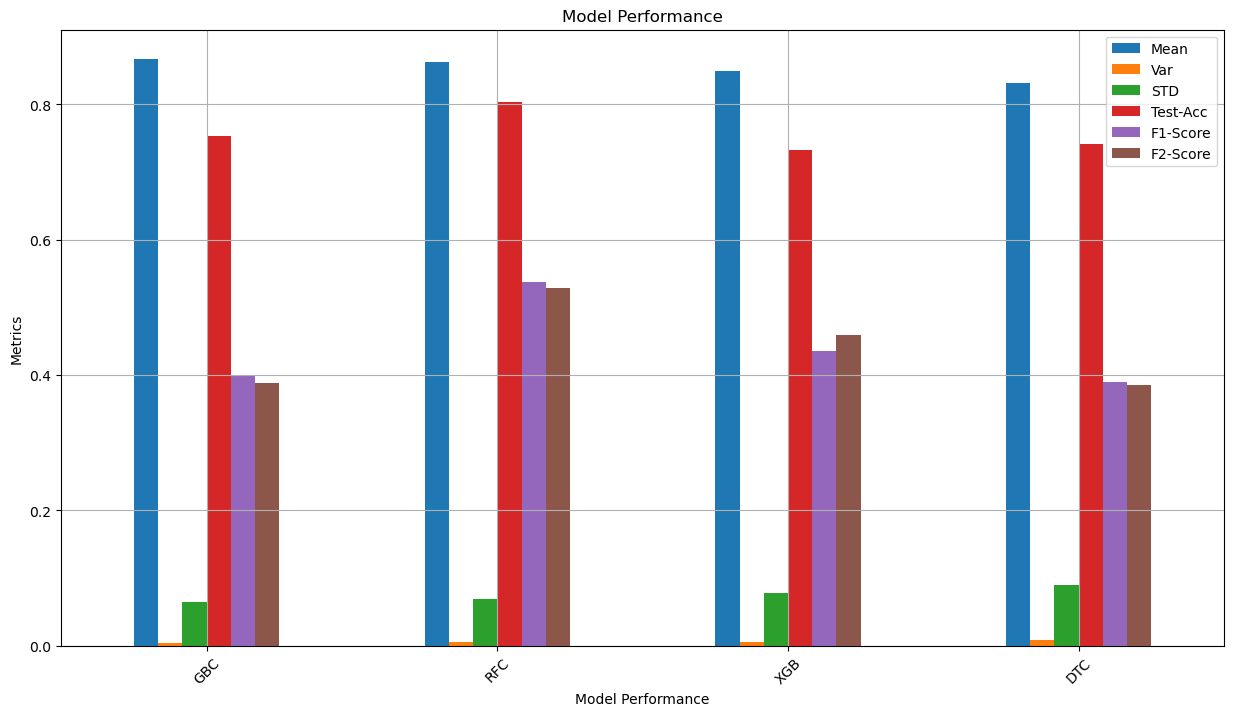

   index Model   Mean    Var    STD  Test-Acc  F1-Score  F2-Score
0      1   GBC  0.867  0.004  0.065     0.753     0.400     0.388
1      0   RFC  0.863  0.005  0.069     0.804     0.537     0.529
2      3   XGB  0.850  0.006  0.078     0.732     0.435     0.459
3      2   DTC  0.831  0.008  0.089     0.742     0.390     0.385


In [20]:
model_names = ["RFC", "GBC", "DTC", "XGB"]
models = grab_selected_models(model_names)
test_selected_models(model_names, models, X, y, acc_metric)

# Notice the scoring differences between f1_score vs Acc_score which shows us how much of a class imbalance exists

# Lets Try Some Sampling Methods and evaluate performance metrics

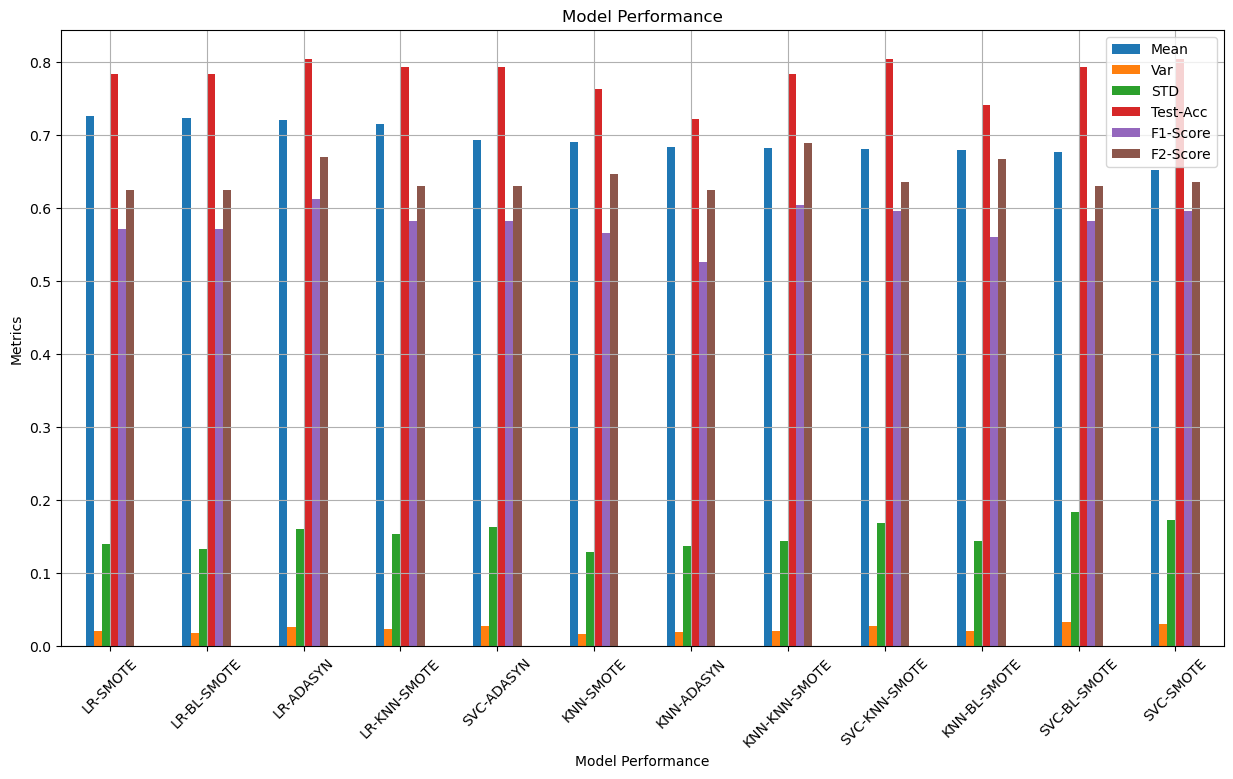

    index          Model   Mean    Var    STD  Test-Acc  F1-Score  F2-Score
0       1       LR-SMOTE  0.726  0.020  0.140     0.784     0.571     0.625
1       7    LR-BL-SMOTE  0.724  0.018  0.133     0.784     0.571     0.625
2       4      LR-ADASYN  0.721  0.026  0.161     0.804     0.612     0.670
3      10   LR-KNN-SMOTE  0.715  0.024  0.154     0.794     0.583     0.631
4       3     SVC-ADASYN  0.694  0.027  0.163     0.794     0.583     0.631
5       2      KNN-SMOTE  0.691  0.017  0.129     0.763     0.566     0.647
6       5     KNN-ADASYN  0.684  0.019  0.137     0.722     0.526     0.625
7      11  KNN-KNN-SMOTE  0.682  0.021  0.144     0.784     0.604     0.690
8       9  SVC-KNN-SMOTE  0.681  0.028  0.169     0.804     0.596     0.636
9       8   KNN-BL-SMOTE  0.680  0.021  0.144     0.742     0.561     0.667
10      6   SVC-BL-SMOTE  0.677  0.033  0.183     0.794     0.583     0.631
11      0      SVC-SMOTE  0.653  0.030  0.173     0.804     0.596     0.636


In [21]:
sampling_model_names = ["SMOTE", "ADASYN", "BL-SMOTE", "KNN-SMOTE"]
sampling_models = grab_selected_sampling_models(sampling_model_names)

model_names = ["SVC", "LR", "KNN"]
models = grab_selected_models(model_names)

test_selected_sampling_models(
  sampling_model_names, 
  sampling_models,
  model_names,
  models,
  X, 
  y, 
  f1_metric
  )

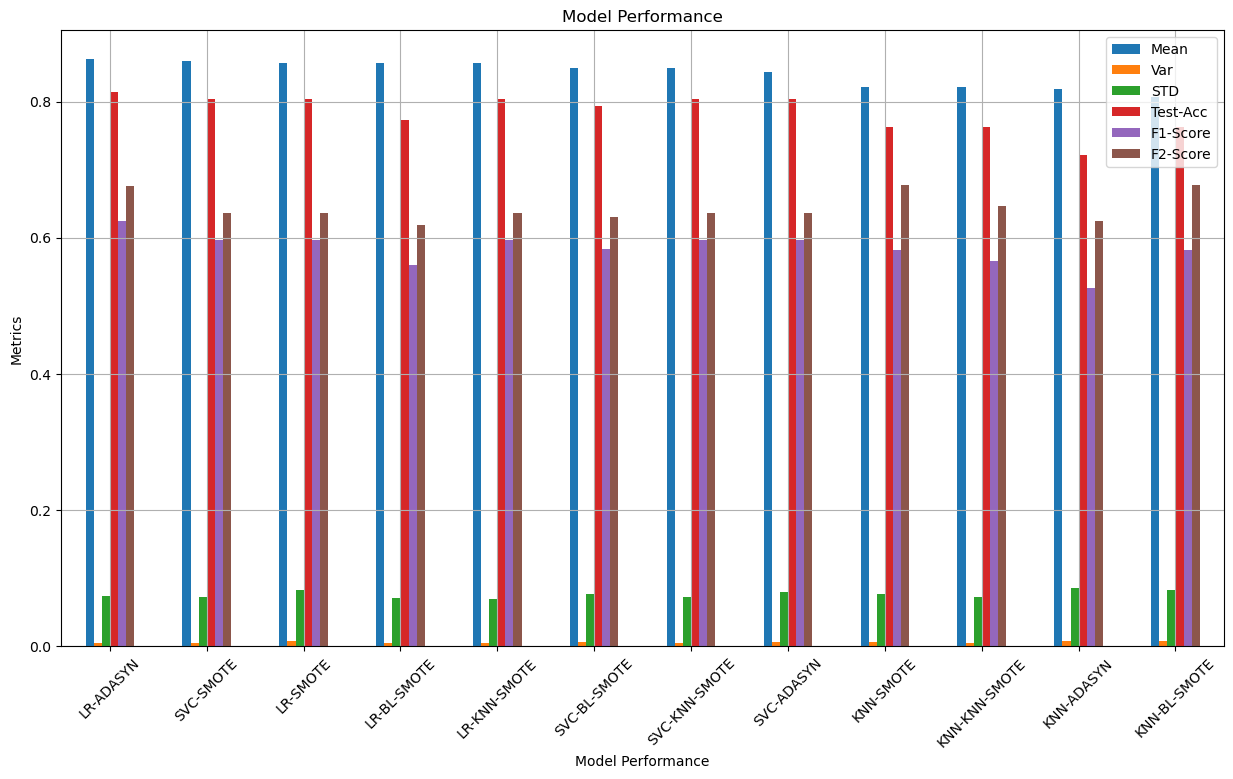

    index          Model   Mean    Var    STD  Test-Acc  F1-Score  F2-Score
0       4      LR-ADASYN  0.862  0.005  0.073     0.814     0.625     0.676
1       0      SVC-SMOTE  0.859  0.005  0.072     0.804     0.596     0.636
2       1       LR-SMOTE  0.857  0.007  0.082     0.804     0.596     0.636
3       7    LR-BL-SMOTE  0.856  0.005  0.070     0.773     0.560     0.619
4      10   LR-KNN-SMOTE  0.856  0.005  0.069     0.804     0.596     0.636
5       6   SVC-BL-SMOTE  0.850  0.006  0.077     0.794     0.583     0.631
6       9  SVC-KNN-SMOTE  0.850  0.005  0.072     0.804     0.596     0.636
7       3     SVC-ADASYN  0.844  0.006  0.079     0.804     0.596     0.636
8       2      KNN-SMOTE  0.822  0.006  0.077     0.763     0.582     0.678
9      11  KNN-KNN-SMOTE  0.821  0.005  0.072     0.763     0.566     0.647
10      5     KNN-ADASYN  0.819  0.007  0.085     0.722     0.526     0.625
11      8   KNN-BL-SMOTE  0.807  0.007  0.082     0.763     0.582     0.678


In [22]:
test_selected_sampling_models(
  sampling_model_names, 
  sampling_models,
  model_names,
  models,
  X, 
  y, 
  acc_metric
  )

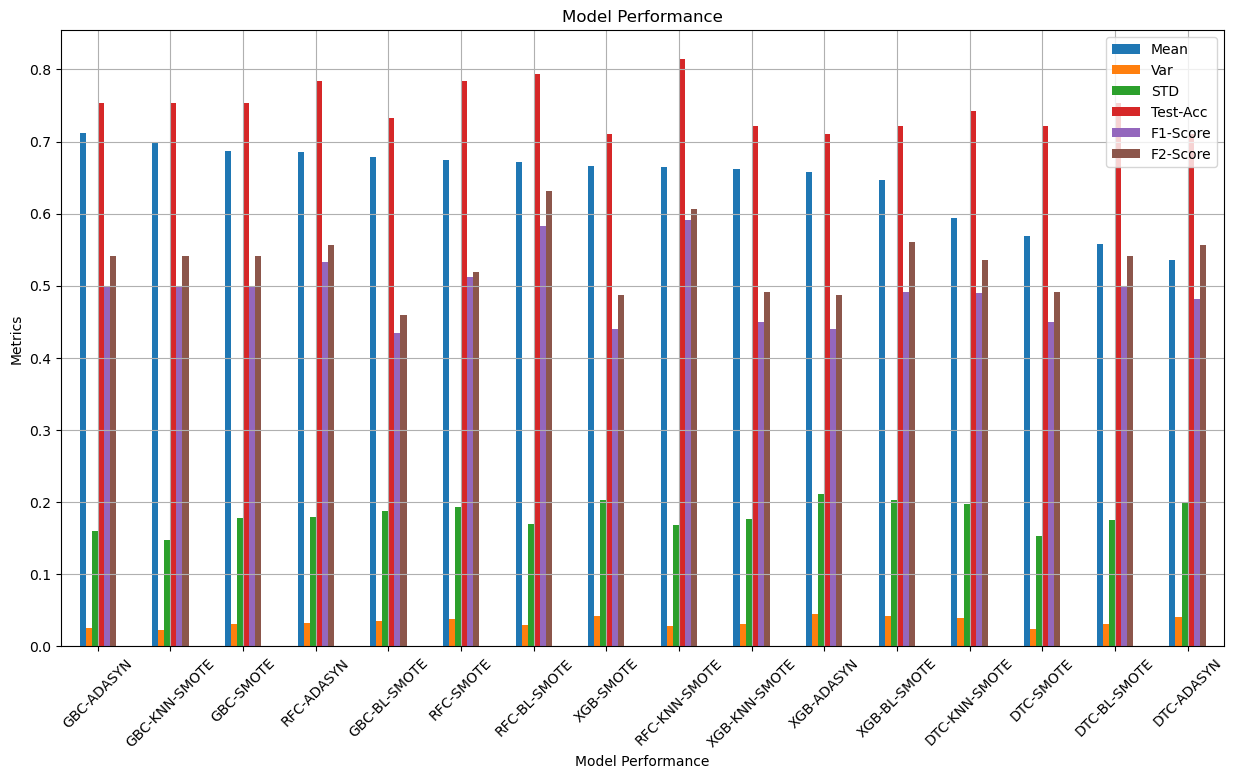

    index          Model   Mean    Var    STD  Test-Acc  F1-Score  F2-Score
0       5     GBC-ADASYN  0.712  0.025  0.159     0.753     0.500     0.541
1      13  GBC-KNN-SMOTE  0.698  0.022  0.147     0.753     0.500     0.541
2       1      GBC-SMOTE  0.687  0.031  0.177     0.753     0.500     0.541
3       4     RFC-ADASYN  0.686  0.032  0.179     0.784     0.533     0.556
4       9   GBC-BL-SMOTE  0.679  0.035  0.187     0.732     0.435     0.459
5       0      RFC-SMOTE  0.675  0.037  0.193     0.784     0.512     0.519
6       8   RFC-BL-SMOTE  0.672  0.029  0.170     0.794     0.583     0.631
7       3      XGB-SMOTE  0.666  0.041  0.202     0.711     0.440     0.487
8      12  RFC-KNN-SMOTE  0.664  0.028  0.168     0.814     0.591     0.607
9      15  XGB-KNN-SMOTE  0.662  0.031  0.176     0.722     0.449     0.491
10      7     XGB-ADASYN  0.658  0.044  0.211     0.711     0.440     0.487
11     11   XGB-BL-SMOTE  0.646  0.041  0.202     0.722     0.491     0.560
12     14  D

In [23]:
model_names = ["RFC", "GBC", "DTC", "XGB"]
models = grab_selected_models(model_names)

test_selected_sampling_models(
  sampling_model_names, 
  sampling_models,
  model_names,
  models,
  X, 
  y, 
  f1_metric
  )

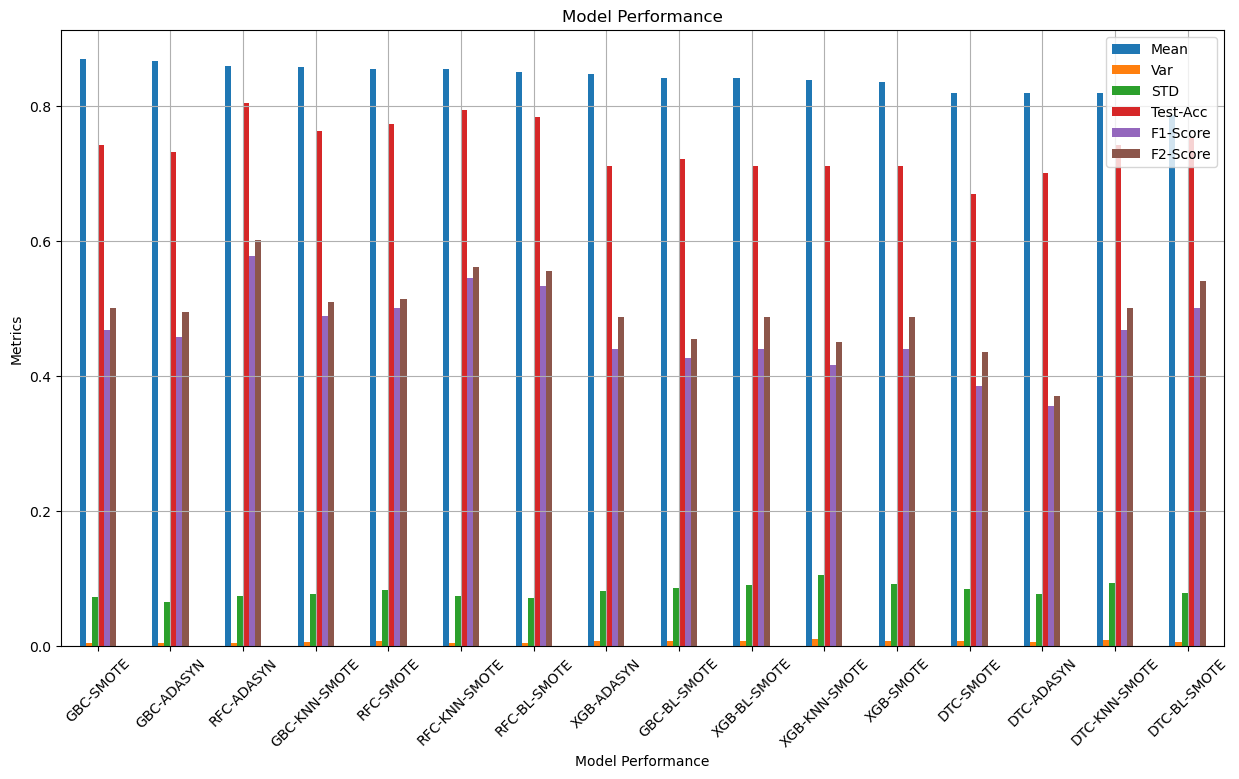

    index          Model   Mean    Var    STD  Test-Acc  F1-Score  F2-Score
0       1      GBC-SMOTE  0.869  0.005  0.073     0.742     0.468     0.500
1       5     GBC-ADASYN  0.867  0.004  0.065     0.732     0.458     0.495
2       4     RFC-ADASYN  0.859  0.005  0.074     0.804     0.578     0.602
3      13  GBC-KNN-SMOTE  0.857  0.006  0.077     0.763     0.489     0.509
4       0      RFC-SMOTE  0.855  0.007  0.083     0.773     0.500     0.514
5      12  RFC-KNN-SMOTE  0.854  0.005  0.074     0.794     0.545     0.561
6       8   RFC-BL-SMOTE  0.850  0.005  0.071     0.784     0.533     0.556
7       7     XGB-ADASYN  0.848  0.007  0.082     0.711     0.440     0.487
8       9   GBC-BL-SMOTE  0.842  0.007  0.086     0.722     0.426     0.455
9      11   XGB-BL-SMOTE  0.842  0.008  0.091     0.711     0.440     0.487
10     15  XGB-KNN-SMOTE  0.838  0.011  0.105     0.711     0.417     0.450
11      3      XGB-SMOTE  0.836  0.008  0.092     0.711     0.440     0.487
12      2   

In [24]:
model_names = ["RFC", "GBC", "DTC", "XGB"]
models = grab_selected_models(model_names)

test_selected_sampling_models(
  sampling_model_names, 
  sampling_models,
  model_names,
  models,
  X, 
  y, 
  acc_metric
  )

# Models I want to test based off of scoring Metrics.
- MODEL  MEAN  VAR  STD     TEST-ACC     F1-SCORE     F2-SCORE 
- **************************************************************
- RFC-BL-SMOTE  0.676  0.033  0.182     0.804     0.596     0.636
- GBC-SMOTE  0.696  0.042  0.206     0.753     0.520     0.575
- RFC-KNN-SMOTE  0.696  0.028  0.167     0.784     0.533     0.556
- LR-ADASYN  0.696  0.025  0.158     0.804     0.612     0.670

In [32]:
RFC_BL_SMOTE_PIPELINE = create_imb_pipeline(
  "BL-SMOTE",
  BorderlineSMOTE(),
  "model",
  RandomForestClassifier()
)

GBC_SMOTE_PIPELINE = create_imb_pipeline(
  "SMOTE",
  BorderlineSMOTE(),
  "model",
  GradientBoostingClassifier()
)

RFC_KNN_SMOTE_PIPELINE = create_imb_pipeline(
  "KNN-SMOTE",
  SMOTE(k_neighbors=5),
  "model",
  RandomForestClassifier()
)

LR_ADASYN_PIPELINE = create_imb_pipeline(
  "ADASYN",
  ADASYN(),
  "model",
  LogisticRegression(max_iter=2000)
)


The Best Params: {'model__max_depth': 30, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 100}


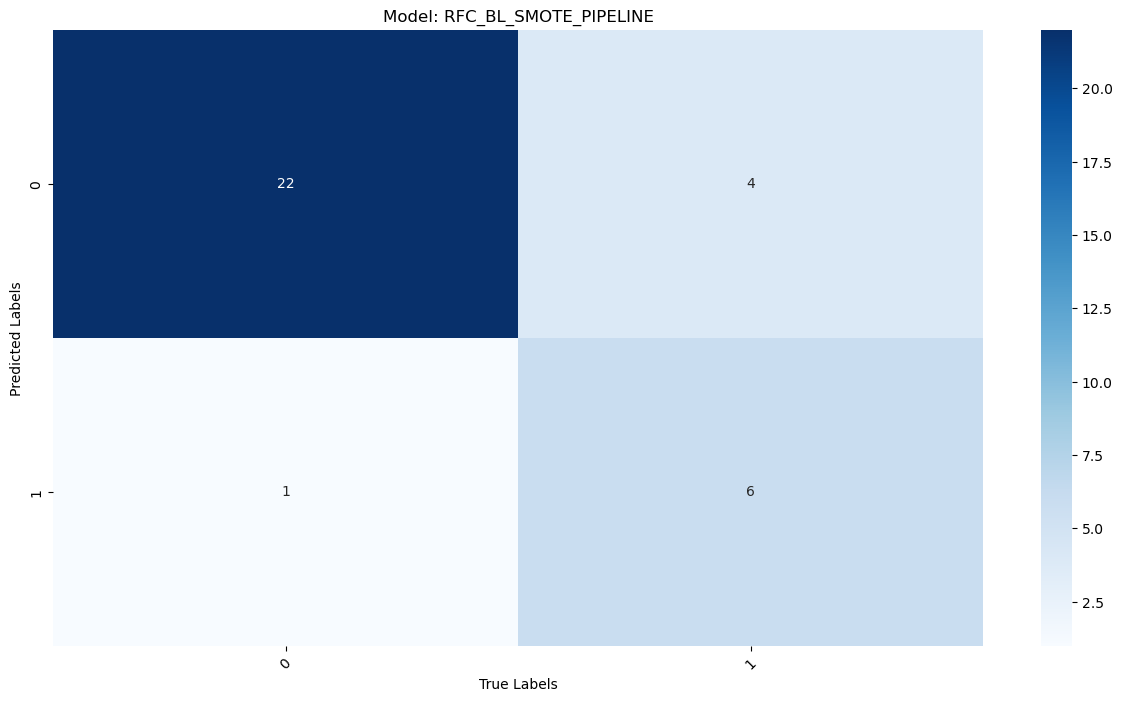

The Best Params: {'model__learning_rate': 0.01, 'model__max_depth': 30, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 300}


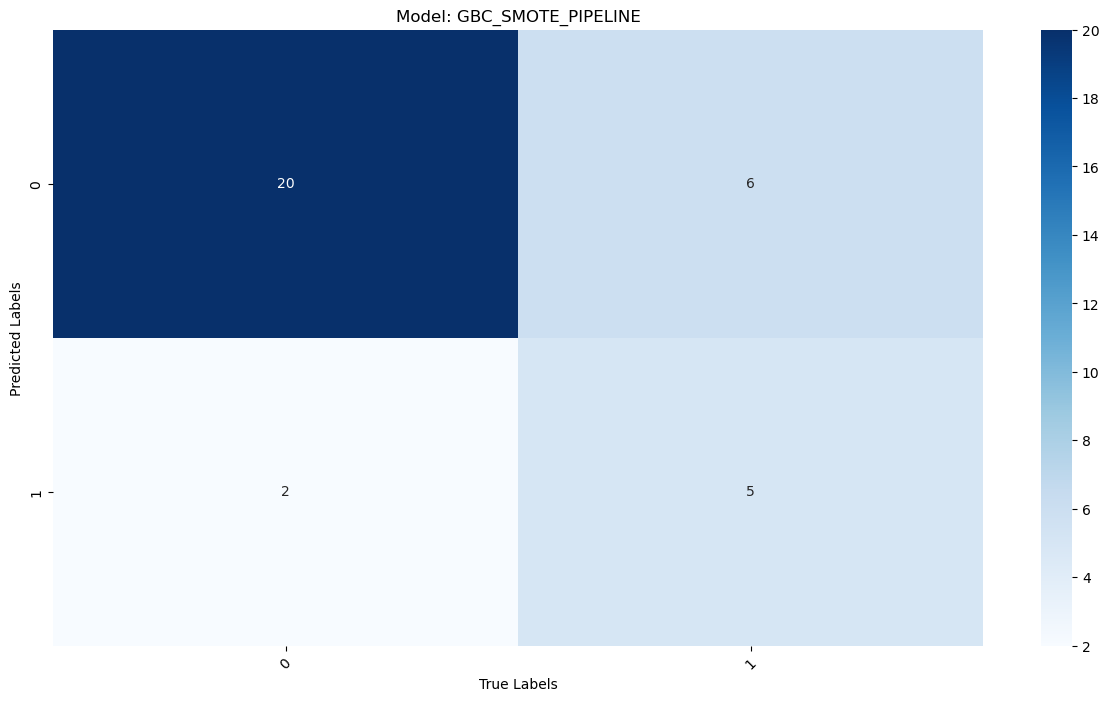

The Best Params: {'model__max_depth': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 300}


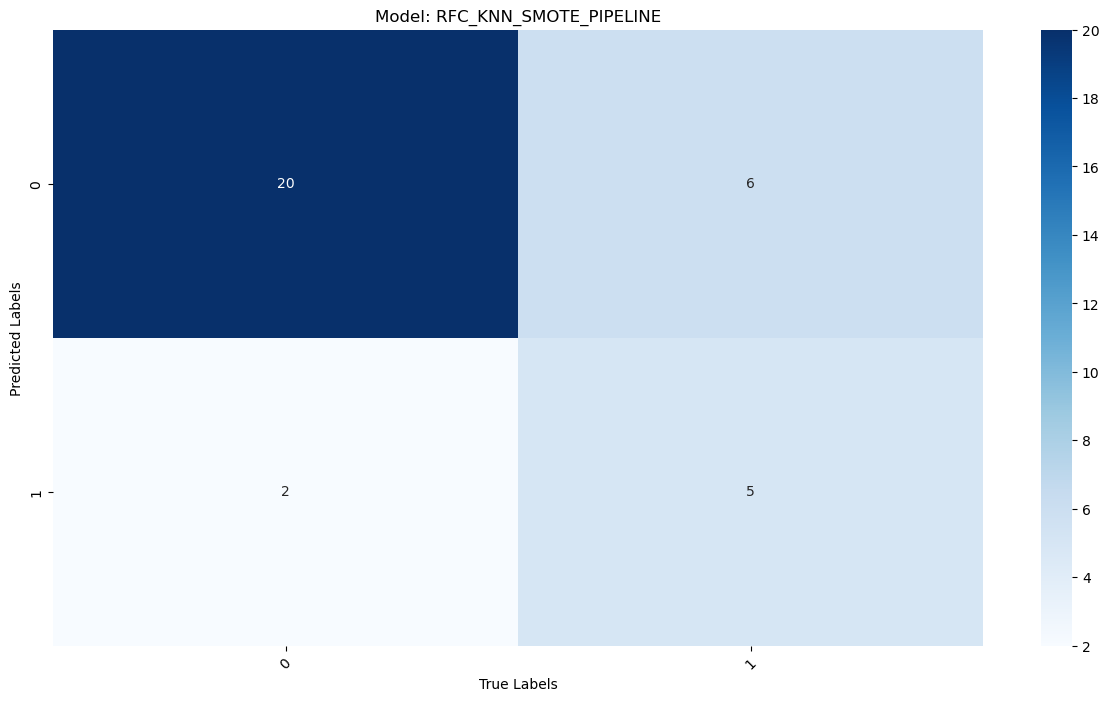

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarni

The Best Params: {'model__C': 0.01, 'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'saga'}


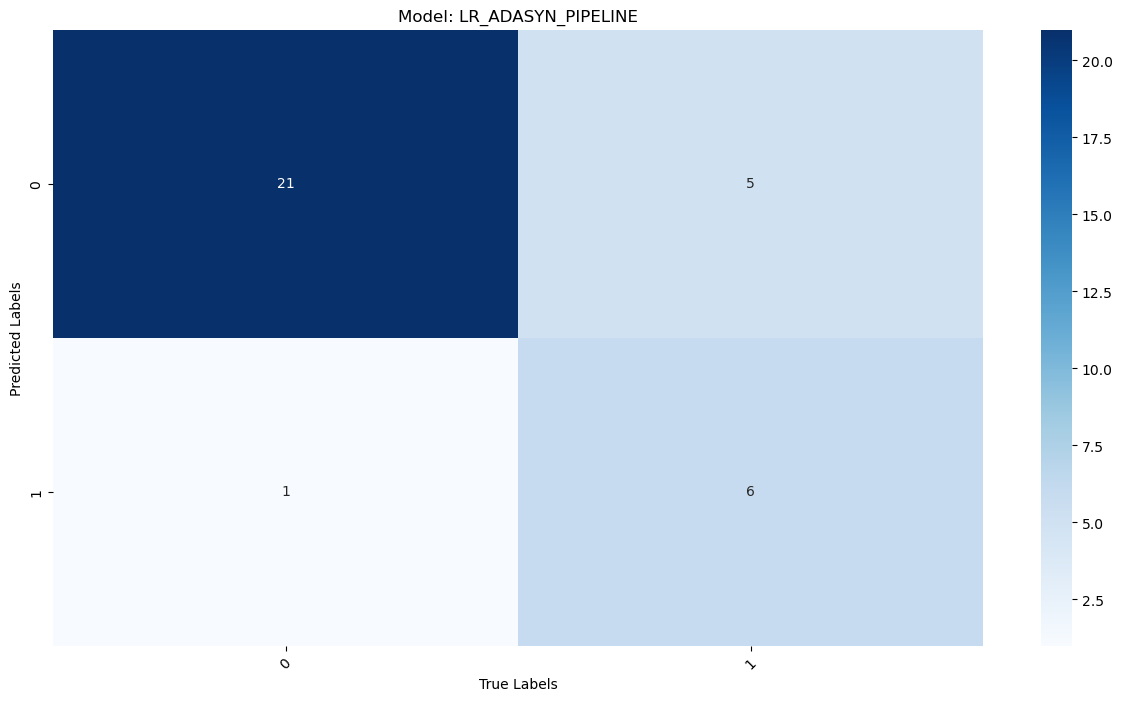

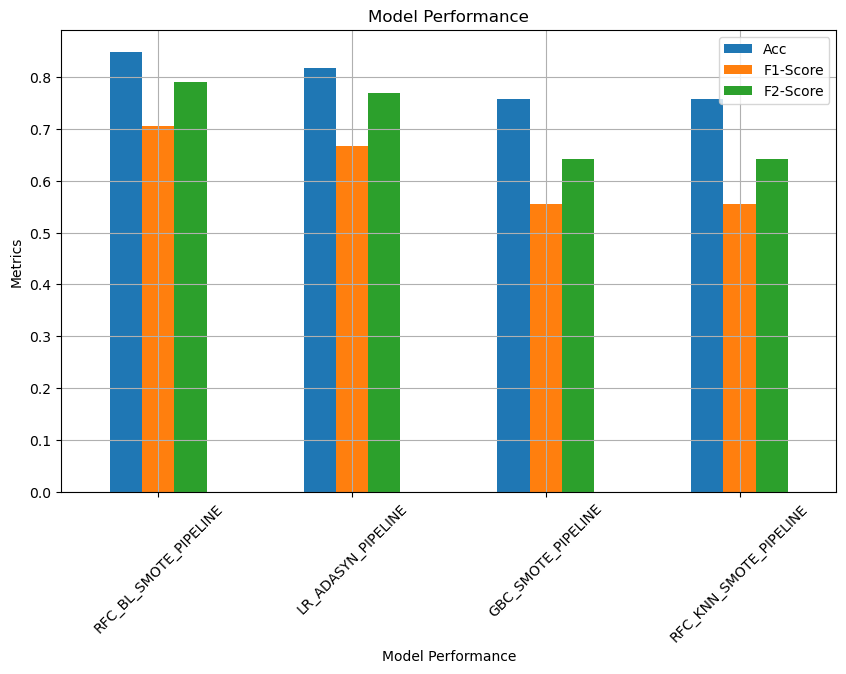

   index                   Model       Acc  F1-Score  F2-Score
0      0   RFC_BL_SMOTE_PIPELINE  0.848485  0.705882  0.789474
1      3      LR_ADASYN_PIPELINE  0.818182  0.666667  0.769231
2      1      GBC_SMOTE_PIPELINE  0.757576  0.555556  0.641026
3      2  RFC_KNN_SMOTE_PIPELINE  0.757576  0.555556  0.641026


In [40]:
pipelines = [
  RFC_BL_SMOTE_PIPELINE,
  GBC_SMOTE_PIPELINE,
  RFC_KNN_SMOTE_PIPELINE,
  LR_ADASYN_PIPELINE
]
params = {
  "RFC_BL_SMOTE_PIPELINE":{

    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
  },
  
  "GBC_SMOTE_PIPELINE":{
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
  },
  
  "RFC_KNN_SMOTE_PIPELINE":{

    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
  },
  
  "LR_ADASYN_PIPELINE":{
    'model__C': [0.01, 0.1, 1, 10],
    'model__solver': ['liblinear', 'saga'],
    'model__penalty': ['l1', 'l2'],
    'model__max_iter': [100, 200, 300],
  }
  
}

pipeline_names = ["RFC_BL_SMOTE_PIPELINE", "GBC_SMOTE_PIPELINE", "RFC_KNN_SMOTE_PIPELINE", "LR_ADASYN_PIPELINE"]
grid_search(X, y, pipelines, params, pipeline_names)

# Let's Create an ensemble model to test our best models

In [42]:
log_clf = LogisticRegression(C=0.01, max_iter=100, penalty='l2', solver='saga')
gbc_clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=300)
rfc_clf = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100)

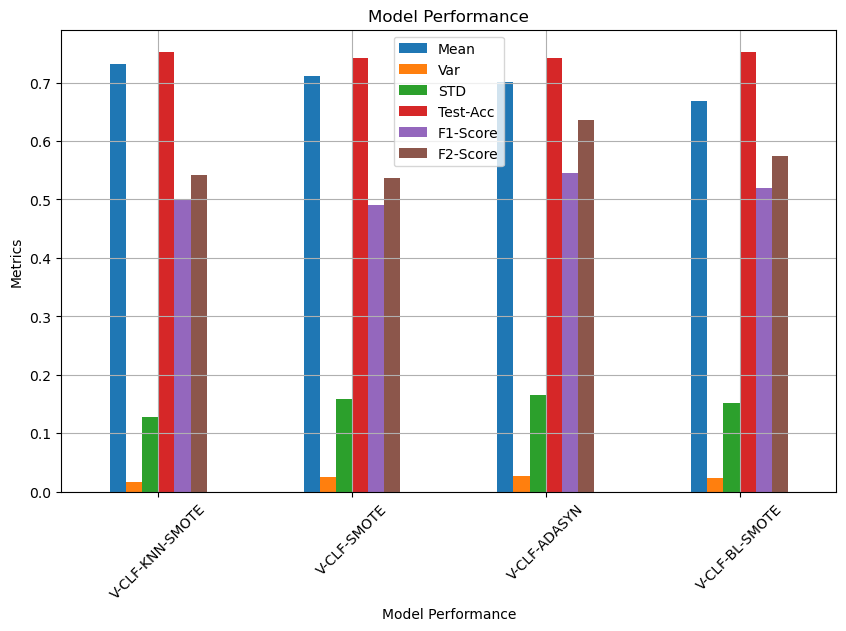

   index            Model   Mean    Var    STD  Test-Acc  F1-Score  F2-Score
0      3  V-CLF-KNN-SMOTE  0.732  0.016  0.128     0.753     0.500     0.541
1      0      V-CLF-SMOTE  0.712  0.025  0.159     0.742     0.490     0.536
2      1     V-CLF-ADASYN  0.701  0.027  0.165     0.742     0.545     0.636
3      2   V-CLF-BL-SMOTE  0.669  0.023  0.151     0.753     0.520     0.575


In [43]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('gbc', gbc_clf),
        ('rfc', rfc_clf)
    ],
    voting='soft'
)

model_names = ["V-CLF"]
models = [voting_clf]

test_selected_sampling_models(sampling_model_names, sampling_models, model_names, models, X, y, f1_metric)

In [44]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('gbc', gbc_clf),
        ('rfc', rfc_clf)
    ],
    voting='soft'
)

model_names = ["V-CLF"]
models = [voting_clf]

test_selected_sampling_models(sampling_model_names, sampling_models, model_names, models, X, y, acc_metric)